In [1]:
import gym
import gym_anytrading
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import random
import pandas as pd

tf.keras.backend.clear_session()


In [6]:
# Define the Agent class
class Agent:
    def __init__(self, actor_lr, critic_lr, discount_factor=0.99, n_actions=2):
        # Initialize the agent with learning rates, discount factor, and number of actions
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.discount_factor = discount_factor
        self.n_actions = n_actions
        
        self.actor, self.actor_grad = self.build_actor_network()
        self.critic = self.build_critic_network()
        self.action_space = [i for i in range(self.n_actions)]
        
    def build_actor_network(self):
        # Define the actor network architecture
        visible = layers.Input(shape=(10,2))
        flatten = layers.Flatten()(visible)
        layer = layers.Dense(64, activation='relu')(flatten)
        layer = layers.Dense(128, activation='relu')(layer)
        layer = layers.Dense(128, activation='relu')(layer)
        layer = layers.Dense(64, activation='relu')(layer)
        probs = layers.Dense(self.n_actions, activation='softmax')(layer)
        
        model = keras.Model(inputs=visible, outputs=probs)

        # Define the custom loss function for the actor network
        def loss(model, x, y_true, delta):
            y_pred = model(x)
            out = K.clip(y_pred, 1e-8, 1-1e-8)
            log_likelihood = y_true * K.log(out)
            return K.sum(-log_likelihood * delta)
            
        # Define the gradient calculation for the actor network
        def grad(model, inputs, targets, delta):
            with tf.GradientTape() as tape:
                loss_value = loss(model, inputs, targets, delta)
            return loss_value, tape.gradient(loss_value, model.trainable_variables)
        
        return model, grad
    
    def build_critic_network(self):
        # Define the critic network architecture
        visible = keras.Input(shape=(10,2))
        flatten = layers.Flatten()(visible)
        layer = layers.Dense(64, activation='relu')(flatten)
        layer = layers.Dense(128, activation='relu')(layer)
        layer = layers.Dense(128, activation='relu')(layer)
        layer = layers.Dense(64, activation='relu')(layer)
        layer = layers.Dense(1, activation='linear')(layer)
        model = keras.Model(inputs=visible, outputs=layer)
        
        model.compile(optimizer=keras.optimizers.Adam(lr=self.critic_lr), loss='mse')
        return model
        
    def build_actor_critic_network(self):
        visible = layers.Input(shape=(10,2))
        flatten = layers.Flatten()(visible)
        delta = layers.Input(shape=[1])
        dense1 = layers.Dense(32, activation='relu')(flatten)
        dense2 = layers.Dense(64, activation='relu')(dense1)
        probs = layers.Dense(self.n_actions, activation='softmax')(dense2)
        values = layers.Dense(1, activation='linear')(dense2)

        # Define the custom loss function for the actor network
        def custom_loss(y_true, y_pred):
            out = K.clip(y_pred, 1e-8, 1-1e-8)
            log_likelihood = y_true * K.log(out)
            
            return K.sum(-log_likelihood * delta)
        actor = keras.Model(inputs=[visible, delta], outputs=[probs])
        actor.compile(optimizer=keras.optimizers.Adam(lr=self.actor_lr), loss=custom_loss)
        critic = keras.Model(inputs=[visible], outputs=[values])
        critic.compile(optimizer=keras.optimizers.Adam(lr=self.critic_lr), loss='mse')
        
        policy = keras.Model(inputs=[visible], outputs=[probs])
        return actor, critic, policy
    def choose_action(self, observation):
        # Choose an action based on the current policy
        state = observation[np.newaxis, :]
        probabilities = self.actor.predict(state)[0]
        action = np.random.choice(self.action_space, p=probabilities)
        
        return action
    
    def learn(self, state, action, reward, state2, done):
        # Update the actor and critic networks based on the observed transition
        state = state[np.newaxis, :]
        state2 = state2[np.newaxis, :]
        critic_value = self.critic.predict(state)
        critic_value2 = self.critic.predict(state2)
            
        target = reward + self.discount_factor * critic_value2 * (1-int(done))
        delta = target - critic_value
        
        actions = np.zeros([1, self.n_actions])
        actions[np.arange(1), action] = 1.0
        

        optimizer = keras.optimizers.Adam(lr=self.actor_lr)
        loss_value, grads = self.actor_grad(self.actor, state, actions, delta)
        #print(state)
        #print(target)
        self.critic.fit(state, target, verbose=0)
        
        #self.actor.fit([state, delta], actions)
        #self.critic.fit(state, target)
        

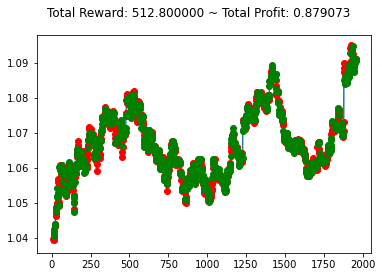

In [7]:
# Initialize the Forex trading environment and the agent
env = gym.make('forex-v0', frame_bound=(50, 2000), window_size=10)
agent = Agent(actor_lr = 0.002, critic_lr = 0.002)
observation = env.reset()
done = False

# Run the agent in the environment
while not done:
    action = agent.choose_action(observation)
    observation2, reward, done, info = env.step(action)
    agent.learn(observation, action, reward, observation2, done)
    observation = observation2

plt.cla()
env.render_all()
plt.show()

info: {'total_reward': -482.5999999999349, 'total_profit': 0.8343946709712124, 'position': 1}


d:\tech\mtech\sls\project\env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


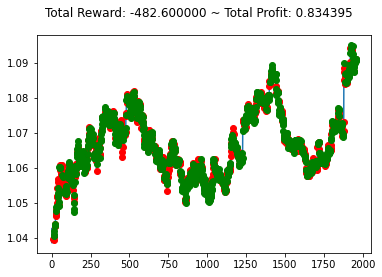

In [8]:
#sample baseline with random actions
env = gym.make('forex-v0', frame_bound=(50, 2000), window_size=10)

observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.render_all()
plt.show()